In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import math
import re

# Colors
light_ioite = "#8462FF"
ioite = "#6236FF"
dark_ioite = "#5329E6"
very_dark_ioite = "#3F21A8"
apatite = "#32C5FF"
ruby = "#E02020"
light_ruby = "#FF6868"
amazonite = "#44D7B6"
dark_amazonite = "#339C84"
very_dark_amazonite = "#0A5544"
amber = "#FA6400"
dark_amber = "#CE5300"
very_dark_amber = "#A74300"
citrine = "#F7B500"
dark_citrine = "#BB8900"
saphire = "#0091FF"
dark_saphire = "#006FC3"
pink = "#D40272"
graphite="#6D7278"
lightgrey = "#D8D8D8"
amethyst = "#B620E0"
light_amethyst = "#E17BFD"
emerald = "#6DD400"

In [2]:
# Hparams
architecture = "resnet18"
dataset = "cifar10"
epochs = 20
batch_size = 256
lr = 0.01
momentum = 0.9
method_type = "taylor"
norm = True

# Read data
df_acc = pd.read_csv("raw/test_acc.csv")
df_flops = pd.read_csv("raw/test_flops.csv")
df_params = pd.read_csv("raw/test_params.csv")
df_ratio = pd.read_csv("raw/test_ratio_pruned.csv")

# Clean unused rows
df_acc = df_acc[df_acc.columns.drop(list(df_acc.filter(regex='__MIN|__MAX')))]
df_flops = df_flops[df_flops.columns.drop(list(df_flops.filter(regex='__MIN|__MAX')))]
df_params = df_params[df_params.columns.drop(list(df_params.filter(regex='__MIN|__MAX')))]
df_ratio = df_ratio[df_ratio.columns.drop(list(df_ratio.filter(regex='__MIN|__MAX')))]

# On inds of test_pruned, we're at a minimum: 
# Select the index right before for the finetuned metrics right before pruning
def select_from_steps(df):
    idx = df[df["Step"].isin(df_ratio["Step"])].index - 2
    idx = idx.append(pd.Index([df.index[-1]]))
    df = df.loc[idx]
    df = df.reset_index(drop=True)
    return df

df_acc = select_from_steps(df_acc)
df_flops = select_from_steps(df_flops)
df_params = select_from_steps(df_params)

# Insert missing first row into df_ratio
df_ratio.loc[-1] = [df_flops["Step"][0]] + [1.0 for _ in range(len(df_ratio.columns)-1)]  # adding a row
df_ratio.index = df_ratio.index + 1  # shifting index
df_ratio = df_ratio.sort_index()  # sorting by index
ratio_series = df_ratio.iloc[:,1]

In [3]:
def merge_col_name(df, metric:str):
    # step, rank, init_range, acc
    dfs = []
    
    L = len(df)
    
    for col in df.columns:
        if col != "Step":
            r = re.search(r"rank=([\d]+)_initrange=([-.e\d]+)", col)
            rank = int(r.group(1))
            init_range = float(r.group(2))
            
            dfs.append(pd.DataFrame(data = {
                "Ratio": ratio_series,
                metric: df[col],
                "Rank": [rank for _ in range(L)],
                "Init range": [init_range for _ in range(L)],
                
            }))
    return pd.concat(dfs)

df_tot = merge_col_name(df_acc, "Acc").merge(merge_col_name(df_flops, "Flops")).merge(merge_col_name(df_params, "Params"))
df_tot["Acc"] = 100*df_tot["Acc"]
df_tot

,Ratio,Acc,Rank,Init range,Flops,Params
0,1.00,91.546474,1,0.000001,0.56,23373
1,0.95,91.646635,1,0.000001,0.54,22963
2,0.90,91.897035,1,0.000001,0.52,22555
3,0.85,90.875401,1,0.000001,0.49,22148
4,0.80,90.184295,1,0.000001,0.47,21732
...,...,...,...,...,...,...
655,0.25,89.933894,16,0.010000,0.18,55210
656,0.20,89.443109,16,0.010000,0.15,48650
657,0.15,87.790465,16,0.010000,0.11,42042
658,0.10,86.638622,16,0.010000,0.08,35578


[Text(0, 0.5, 'CIFAR10 Acc. (%) @0.80')]

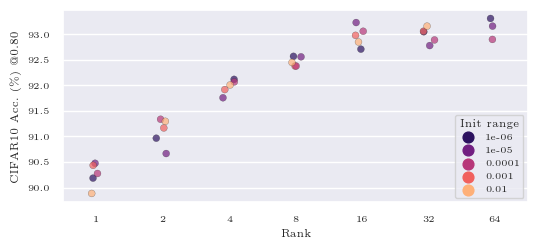

In [24]:
ratio=0.8
df_sel = df_tot[df_tot["Ratio"]==ratio]
sns.set_style({'font.family': 'Latin Modern Roman', "font_scale":0.6})
sns.set(rc={'figure.figsize':(6,2.5), 'font.family': 'Latin Modern Roman'}, context="notebook", font_scale=0.6)
ax = sns.stripplot(data=df_sel, x="Rank", y="Acc", hue="Init range", linewidth=0.2, alpha=0.7, palette="magma", )#palette=[citrine, dark_citrine, amber, dark_amber, very_dark_amber, ])
# ax = sns.catplot(data=df_sel, x="Rank", y="Acc", hue="Init range", linewidth=0.2, color=saphire, kind="point", markers=["^", "o", "d", "s"], linestyles=["-", "--", "-.", ":"],)
# ax = sns.stripplot(data=df_sel, x="Rank", y="Acc",  linewidth=0.2, color=saphire, alpha=0.7)
plt.legend(loc='lower right', title='Init range')
ax.yaxis.grid(True)
ax.set(ylabel=f'CIFAR10 Acc. (%) @{ratio:.2f}')
# ax.xaxis.grid(False)# Hide the horizontal gridlines

In [10]:
# df_sel = df_tot[df_tot["Ratio"]==ratio]
df_sel =df_tot.groupby(["Init range", "Rank"]).mean()
# df_sel.pivot(index = "Init range", columns = "Rank", values = "Acc")
df_sel["Acc"].unstack()

Rank,1,2,4,8,16,32,64
Init range,,,,,,,
0.000001,82.553586,85.496294,87.762420,89.419571,90.816306,91.300581,91.632612
0.000010,82.885116,85.241887,87.539563,89.676482,90.827825,91.313101,91.357672
0.000100,82.358774,85.316006,87.702825,89.647937,91.111779,91.379708,91.268530
0.001000,82.125401,85.049579,87.579127,89.662961,90.968049,91.269030,NaN
0.010000,82.550581,85.487280,87.764423,89.726062,90.906951,91.588542,NaN


<AxesSubplot:xlabel='Rank', ylabel='Init range'>

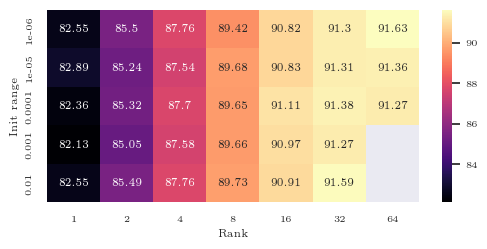

In [11]:
ratio=0.5
# df_sel = df_tot[df_tot["Ratio"]==ratio].pivot(index = "Init range", columns = "Rank", values = "Acc")
df_sel  = df_tot.groupby(["Init range", "Rank"]).mean()["Acc"].unstack()
sns.heatmap(df_sel,
            annot=True, fmt='.4g', 
            cmap="magma",
           )

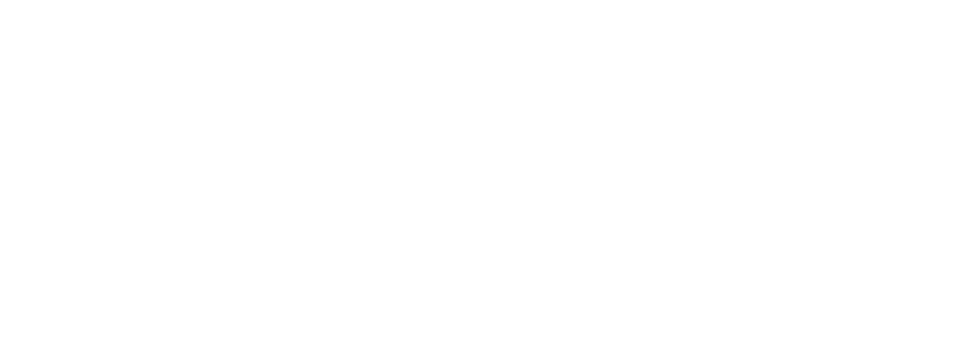

In [ ]:
fig = go.Figure(
    data=[
        go.Surface(
            z=df_tot[df_tot["Ratio"]==ratio].pivot(index = "Init range", columns = "Rank", values = "Acc").to_numpy(), 
            x=sorted(df_tot[df_tot["Ratio"]==ratio]["Rank"].unique()),
            y=sorted(df_tot[df_tot["Ratio"]==ratio]["Init range"].unique()),
            showscale=False, opacity=0.9
        )
        for ratio in [1.0, 0.5, 0.1]
    ],
)

fig.show()